<a href="https://colab.research.google.com/github/Lakshmikha/churn/blob/master/nnchurn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout


import shap

%matplotlib inline

In [ ]:
df=pd.read_csv('with_sentiment (2).csv')
df

,CustomerID,Name,Age,Gender,Geography,Native_Place,Marital_Status,Tenure,Account_Type,Balance,...,Loan_Status,EMI_Amount,Exited,Branch_Code,Account_Open_Date,Last_Transaction_Date,Customer_Review,Emoji_Sentiment,Text_Sentiment,Combined_Sentiment
0,CID000001,Sunita Sharma,21,Other,Tamil Nadu,Hyderabad,Married,4,Current,676699.49,...,Auto,4238.57,0,BR072,2024-03-10,2024-06-23,Reasonable fees 💲,0.0,0.0000,0.00000
1,CID000002,Amit Kumar,53,Male,Karnataka,Pune,Divorced,8,Premium,215313.76,...,Business,30226.31,0,BR094,2020-02-26,2024-08-20,Professional staff 🌟,1.0,0.0000,0.60000
2,CID000003,Rohan Gupta,55,Other,West Bengal,Lucknow,Married,2,Savings,661263.32,...,Education,43308.58,0,BR021,2024-04-07,2024-11-21,Great mobile app 🥰,1.0,0.9081,0.96324
3,CID000004,Sunita Iyer,27,Other,Karnataka,Jaipur,Married,5,NRI,379455.44,...,Business,19905.26,0,BR028,2022-02-15,2024-12-11,Professional staff 🌟,1.0,0.0000,0.60000
4,CID000005,Priya Iyer,76,Male,Tamil Nadu,Bangalore,Married,17,Senior Citizen,747013.81,...,Multiple,27711.22,0,BR015,2021-11-16,2024-07-04,Professional staff 🌟,1.0,0.0000,0.60000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,CID099996,Rohan Gupta,44,Male,Telangana,Chennai,Widowed,14,Joint,678326.81,...,Gold,0.00,0,BR081,2025-03-12,2024-08-31,Great mobile app 🥰,1.0,0.9081,0.96324
99996,CID099997,Amit Singh,62,Male,West Bengal,Bangalore,Widowed,13,Current,836294.17,...,Auto,9337.87,0,BR086,2016-03-02,2024-11-04,Excellent service! 😊,1.0,0.8748,0.94992
99997,CID099998,Sunita Rao,59,Female,Karnataka,Lucknow,Divorced,3,NRI,537264.63,...,Gold,10962.54,0,BR062,2023-04-21,2024-10-17,Great mobile app 🥰,1.0,0.9081,0.96324
99998,CID099999,Neha Gupta,50,Male,Telangana,Pune,Divorced,4,Salary,386295.37,...,Multiple,83598.98,0,BR019,2022-08-07,2024-12-06,No waiting time ⚡,1.0,-0.2960,0.48160


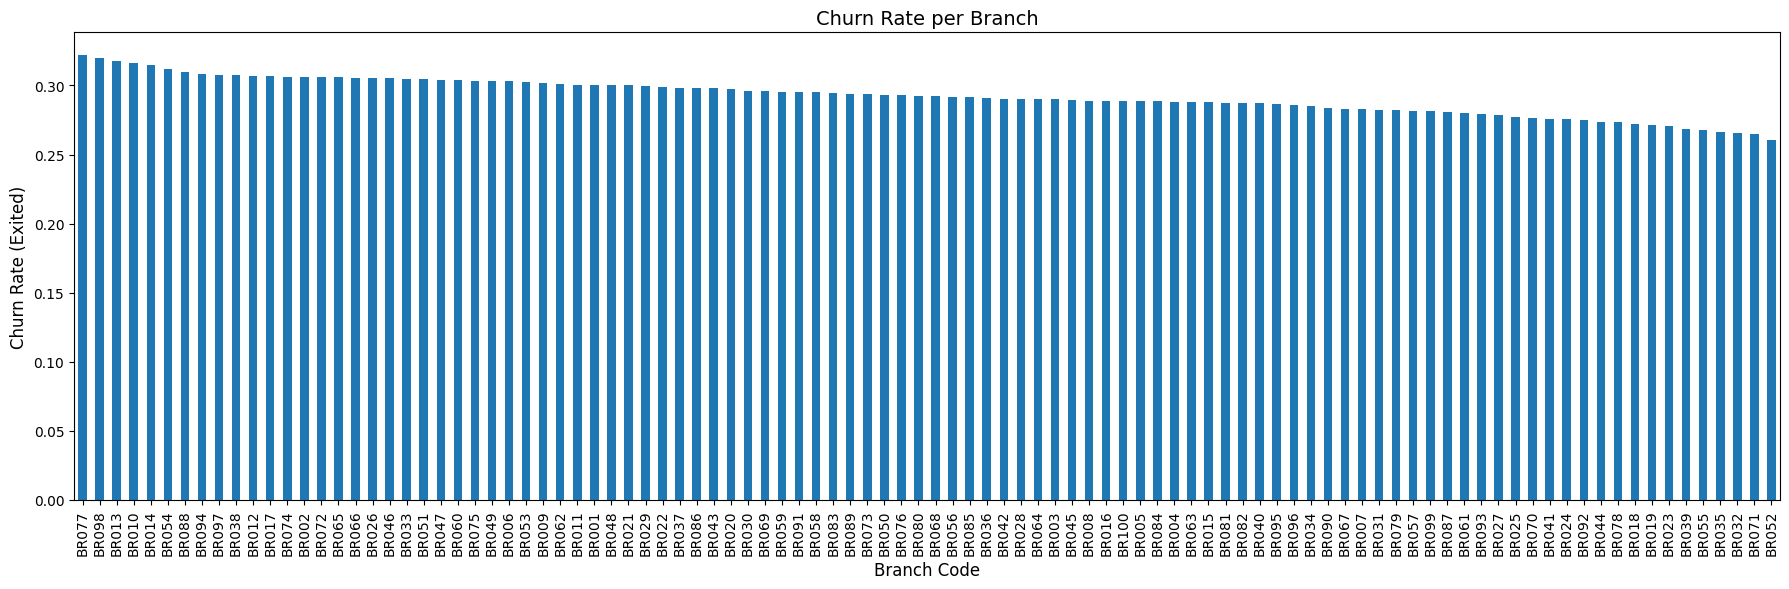

In [ ]:
churn_rate_per_branch = df.groupby('Branch_Code')['Exited'].mean().sort_values(ascending=False)


plt.figure(figsize=(18,6))
churn_rate_per_branch.plot(kind='bar')
plt.ylabel('Churn Rate (Exited)', fontsize=12)
plt.xlabel('Branch Code', fontsize=12)
plt.title('Churn Rate per Branch', fontsize=14)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()



/tmp/ipython-input-324-3155277097.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_means = df.groupby(pd.cut(df['CreditScore'], bins=10))['Exited'].mean()


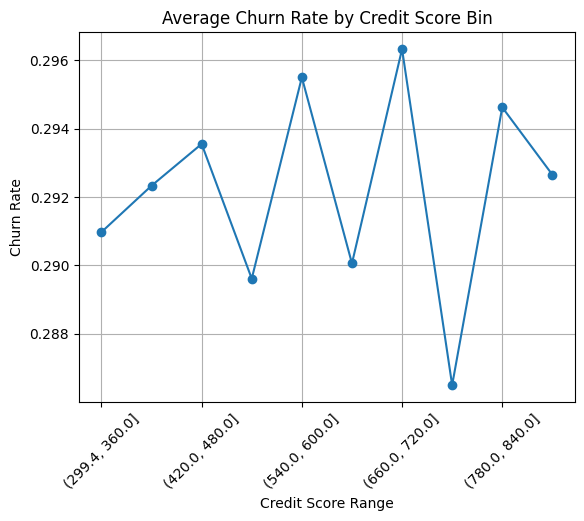

In [ ]:
bin_means = df.groupby(pd.cut(df['CreditScore'], bins=10))['Exited'].mean()
bin_means.plot(kind='line', marker='o')
plt.title('Average Churn Rate by Credit Score Bin')
plt.ylabel('Churn Rate')
plt.xlabel('Credit Score Range')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()



In [ ]:
pd.cut(df['CreditScore'], bins=10).value_counts()


,count
CreditScore,
"(299.4, 360.0]",10348
"(780.0, 840.0]",10067
"(840.0, 900.0]",10046
"(360.0, 420.0]",10016
"(600.0, 660.0]",9998
"(480.0, 540.0]",9972
"(660.0, 720.0]",9918
"(420.0, 480.0]",9913
"(720.0, 780.0]",9871


In [ ]:
df.columns

Index(['CustomerID', 'Name', 'Age', 'Gender', 'Geography', 'Native_Place',
       'Marital_Status', 'Tenure', 'Account_Type', 'Balance', 'NumOfProducts',
       'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Monthly_Income',
       'CreditScore', 'Loan_Status', 'EMI_Amount', 'Exited', 'Branch_Code',
       'Account_Open_Date', 'Last_Transaction_Date', 'Customer_Review',
       'Emoji_Sentiment', 'Text_Sentiment', 'Combined_Sentiment'],
      dtype='object')

<Axes: >

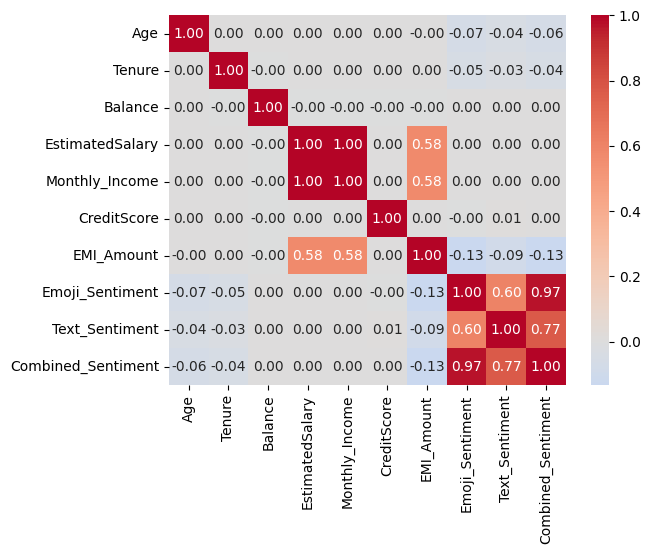

In [ ]:
cont=["Age", "Tenure", "Balance", "EstimatedSalary", "Monthly_Income", "CreditScore", "EMI_Amount","Emoji_Sentiment","Text_Sentiment","Combined_Sentiment"]

corr_matrix=pd.DataFrame(df[cont], columns=cont).corr()

sns.heatmap(corr_matrix, center=0, annot=True, cmap='coolwarm', fmt='.2f')



In [ ]:
df[cont + ['Exited']].corr()['Exited'].sort_values(ascending=False)


,Exited
Exited,1.000000
EMI_Amount,0.221443
Age,0.110089
Tenure,0.068078
Monthly_Income,0.000846
EstimatedSalary,0.000846
CreditScore,-0.000265
Balance,-0.003271
Text_Sentiment,-0.392355
Combined_Sentiment,-0.601516


In [ ]:
df.drop(['CustomerID', 'Name', 'EstimatedSalary', 'Emoji_Sentiment', 'Customer_Review','Account_Open_Date','Last_Transaction_Date'], axis=1, inplace=True)




In [ ]:
df.dtypes

,0
Age,int64
Gender,object
Geography,object
Native_Place,object
Marital_Status,object
Tenure,int64
Account_Type,object
Balance,float64
NumOfProducts,int64
HasCrCard,int64


In [ ]:
df[df.Exited==0].Tenure

,Tenure
0,4
1,8
2,2
3,5
4,17
...,...
99995,14
99996,13
99997,3
99998,4


In [ ]:
for column in df:
  print(f'{column} : {df[column].unique()}')

Age : [21 53 55 27 76 67 82 34 47 70 80 49 45 31 74 63 46 51 60 18 78 26 77 38
 61 24 43 81 73 32 36 66 30 68 22 37 50 59 65 57 52 23 28 75 20 39 41 84
 33 69 71 42 85 64 83 29 19 79 62 35 54 58 25 40 72 48 44 56]
Gender : ['Other' 'Male' 'Female']
Geography : ['Tamil Nadu' 'Karnataka' 'West Bengal' 'Rajasthan' 'Telangana' 'Delhi'
 'Uttar Pradesh' 'Maharashtra' 'Gujarat']
Native_Place : ['Hyderabad' 'Pune' 'Lucknow' 'Jaipur' 'Bangalore' 'Mumbai' 'Delhi'
 'Chennai' 'Kolkata' 'Ahmedabad']
Marital_Status : ['Married' 'Divorced' 'Single' 'Widowed']
Tenure : [ 4  8  2  5 17 20 11  1 13  9  3  7 16 18 15 10  6 14  0 19 12]
Account_Type : ['Current' 'Premium' 'Savings' 'NRI' 'Senior Citizen' 'Salary' 'Joint'
 'Student']
Balance : [676699.49 215313.76 661263.32 ... 537264.63 386295.37 254061.86]
NumOfProducts : [1 3 2 4]
HasCrCard : [1 0]
IsActiveMember : [0 1]
Monthly_Income : [ 21136.25  73655.76 146639.22 ...  62121.14 148833.01 160061.79]
CreditScore : [523 667 689 332 441 745 614 682 585 

In [ ]:
for column in df:
  print(f'{column}: {df[column].isna().sum()}')


Age: 0
Gender: 0
Geography: 0
Native_Place: 0
Marital_Status: 0
Tenure: 0
Account_Type: 0
Balance: 0
NumOfProducts: 0
HasCrCard: 0
IsActiveMember: 0
Monthly_Income: 0
CreditScore: 0
Loan_Status: 0
EMI_Amount: 0
Exited: 0
Branch_Code: 0
Text_Sentiment: 0
Combined_Sentiment: 0


In [ ]:
df = pd.get_dummies(df, columns=['Gender', 'Geography', 'Marital_Status', 'Loan_Status','Native_Place','Account_Type'], drop_first=True)



In [ ]:
df

,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,Monthly_Income,CreditScore,EMI_Amount,Exited,...,Native_Place_Lucknow,Native_Place_Mumbai,Native_Place_Pune,Account_Type_Joint,Account_Type_NRI,Account_Type_Premium,Account_Type_Salary,Account_Type_Savings,Account_Type_Senior Citizen,Account_Type_Student
0,21,4,676699.49,1,1,0,21136.25,523,4238.57,0,...,False,False,False,False,False,False,False,False,False,False
1,53,8,215313.76,3,0,0,73655.76,667,30226.31,0,...,False,False,True,False,False,True,False,False,False,False
2,55,2,661263.32,3,0,0,146639.22,689,43308.58,0,...,True,False,False,False,False,False,False,True,False,False
3,27,5,379455.44,2,1,0,51023.88,332,19905.26,0,...,False,False,False,False,True,False,False,False,False,False
4,76,17,747013.81,4,1,1,49564.78,441,27711.22,0,...,False,False,False,False,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,44,14,678326.81,1,1,1,48963.14,530,0.00,0,...,False,False,False,True,False,False,False,False,False,False
99996,62,13,836294.17,3,0,1,41289.71,864,9337.87,0,...,False,False,False,False,False,False,False,False,False,False
99997,59,3,537264.63,4,0,0,62121.14,486,10962.54,0,...,True,False,False,False,True,False,False,False,False,False
99998,50,4,386295.37,4,0,1,148833.01,512,83598.98,0,...,False,False,True,False,False,False,True,False,False,False


In [ ]:
train_df, test_df = train_test_split(df, test_size=0.3, random_state=0, stratify=df['Exited'])

In [ ]:
branch_churn_rate = train_df.groupby('Branch_Code')['Exited'].mean()

In [ ]:
branch_churn_rate

,Exited
Branch_Code,
BR001,0.299107
BR002,0.318047
BR003,0.289593
BR004,0.297101
BR005,0.289958
...,...
BR096,0.294889
BR097,0.306428
BR098,0.309593


In [ ]:
train_df['Branch_Churn_Rate'] = train_df['Branch_Code'].map(branch_churn_rate)
test_df['Branch_Churn_Rate'] = test_df['Branch_Code'].map(branch_churn_rate)


In [ ]:
train_df.drop(columns=['Branch_Code'], inplace=True)
test_df.drop(columns=['Branch_Code'], inplace=True)


In [ ]:
train_df.dtypes

,0
Age,int64
Tenure,int64
Balance,float64
NumOfProducts,int64
HasCrCard,int64
IsActiveMember,int64
Monthly_Income,float64
CreditScore,int64
EMI_Amount,float64
Exited,int64


In [ ]:
len(train_df.columns)

48

In [ ]:
# For training set
X_train = train_df.drop(columns=['Exited'])
y_train = train_df['Exited']

# For testing set
X_test = test_df.drop(columns=['Exited'])
y_test = test_df['Exited']

encoded_columns = X_train.columns.tolist()

In [ ]:
numerical_cols = ['Age', 'NumOfProducts','CreditScore', 'Monthly_Income', 'EMI_Amount', 'Balance', 'Tenure']

In [ ]:
scaler = StandardScaler()
X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])

In [ ]:
X_train

,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,Monthly_Income,CreditScore,EMI_Amount,Text_Sentiment,...,Native_Place_Mumbai,Native_Place_Pune,Account_Type_Joint,Account_Type_NRI,Account_Type_Premium,Account_Type_Salary,Account_Type_Savings,Account_Type_Senior Citizen,Account_Type_Student,Branch_Churn_Rate
43528,-0.586705,1.321826,-1.299899,-0.448604,0,0,-0.628107,-0.052313,0.704603,-0.2960,...,False,False,True,False,False,False,False,False,False,0.255259
14976,-1.551853,-0.827988,-1.108315,-0.448604,0,0,-0.345226,0.511370,-0.277991,0.0000,...,True,False,False,False,False,True,False,False,False,0.301521
87261,-1.043880,0.825715,1.026502,-0.448604,1,1,0.758092,-0.104080,-0.570422,-0.2960,...,False,True,False,False,False,False,True,False,False,0.280000
37106,1.546781,-0.993358,-1.212982,-0.448604,1,0,-1.033409,0.327310,-1.227412,0.2023,...,False,False,False,False,False,True,False,False,False,0.304790
30062,-0.739097,-0.662617,-1.360928,-0.448604,1,0,-0.477939,1.167082,0.181518,0.4754,...,False,False,False,True,False,False,False,False,False,0.318731
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49163,-0.027935,0.660345,1.687667,1.339476,0,0,0.520221,0.258288,0.713658,-0.7506,...,False,False,False,False,False,False,True,False,False,0.300885
31182,0.937213,0.660345,0.186982,-0.448604,1,0,1.610769,-0.104080,1.321749,-0.2960,...,True,False,False,False,False,True,False,False,False,0.309798
56656,0.022862,0.164234,-1.437417,-1.342644,0,0,0.832878,1.305127,-0.201639,0.0000,...,False,False,False,False,False,False,False,False,True,0.291372
94052,0.937213,0.660345,-1.087998,-1.342644,1,0,-0.118513,0.430844,1.271892,-0.2960,...,False,False,False,False,False,False,True,False,False,0.308023


In [ ]:
len(X_train.columns)

47

In [ ]:
model=keras.Sequential([
    keras.layers.Dense(47, input_shape=(47,), activation='relu')
    ,Dropout(0.1),
    keras.layers.Dense(30, activation='relu'),
    Dropout(0.1)
    ,keras.layers.Dense(20, activation='relu'),
    Dropout(0.1)
    ,keras.layers.Dense(10, activation='relu'),
    Dropout(0.1)
    ,keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.fit(X_train, y_train, epochs=25)

Epoch 1/25


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2188/2188 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.8270 - loss: 0.3809
Epoch 2/25
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.8892 - loss: 0.2738
Epoch 3/25
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8918 - loss: 0.2622
Epoch 4/25
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.8897 - loss: 0.2630
Epoch 5/25
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.8952 - loss: 0.2537
Epoch 6/25
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.8935 - loss: 0.2525
Epoch 7/25
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.8942 - loss: 0.2525
Epoch 8/25
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.8940 - loss: 0.2483
Epoch 9/25
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.8958 - loss: 0.2460
Epoch 10/25
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.8982 - loss: 0.2469
Epoch 11/25
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.8972 - loss: 0.2441
Epoch 12/25
2188/2188 ━━━━━━━━━━━━━━

In [ ]:
model.evaluate(X_test, y_test)

938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9008 - loss: 0.2345


[0.24091479182243347, 0.8966666460037231]

In [ ]:
yp=model.predict(X_test)
y_pred_class = (yp > 0.5).astype(int)
y_pred_class[:20]

938/938 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


array([[0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [1],
       [0],
       [1],
       [1]])

In [ ]:
y_test[:20]

,Exited
42234,0
74800,1
77390,0
16611,0
84831,0
40996,1
45908,0
71615,0
59687,0
32403,0


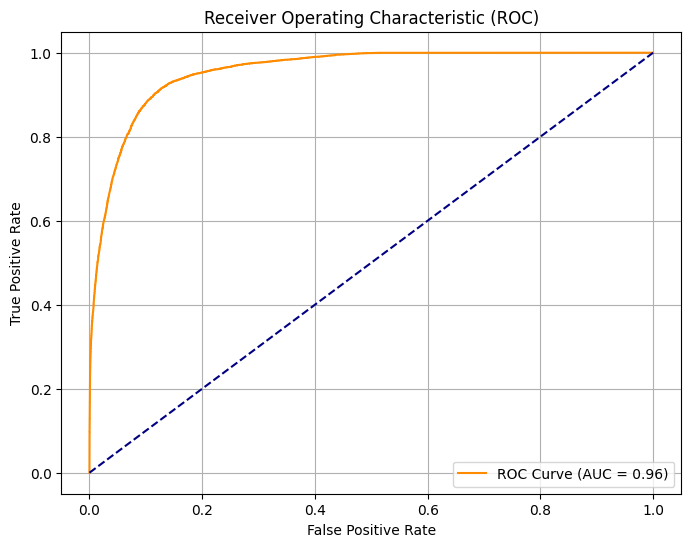

In [ ]:
fpr, tpr, _ = roc_curve(y_test, yp)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend()
plt.grid()
plt.show()



In [ ]:
print(classification_report(y_test, y_pred_class))

              precision    recall  f1-score   support

           0       0.93      0.92      0.93     21234
           1       0.82      0.83      0.83      8766

    accuracy                           0.90     30000
   macro avg       0.87      0.88      0.88     30000
weighted avg       0.90      0.90      0.90     30000



Text(95.72222222222221, 0.5, 'Truth')

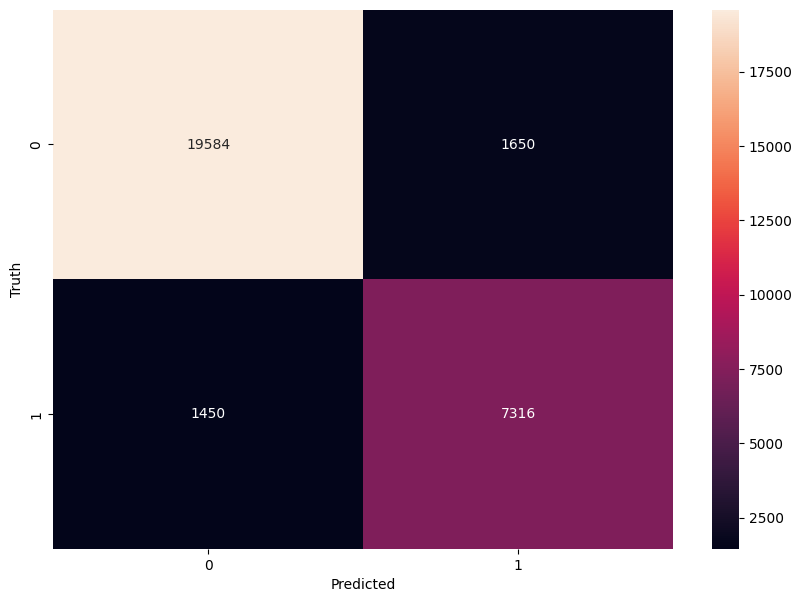

In [ ]:

cm=tf.math.confusion_matrix(labels=y_test, predictions=y_pred_class)
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [ ]:
(19556+6801)/(19556+6801+1965+1678)

0.8785666666666667

In [ ]:
X_test_clean = X_test.copy()
X_test_clean = X_test_clean.apply(pd.to_numeric, errors='coerce')


X_test_clean.fillna(0, inplace=True)


X_test_clean = X_test_clean.astype(np.float32)


In [ ]:
bool_cols = X_train.select_dtypes(include=['bool']).columns
X_train[bool_cols] = X_train[bool_cols].astype(int)



In [ ]:

object_cols = X_train.select_dtypes(include=['object']).columns
for col in object_cols:
    try:
        X_train[col] = pd.to_numeric(X_train[col], errors='raise')
    except:
        print(f"Non-numeric object column found: {col}")


In [ ]:
print(X_test_clean.dtypes)


Age                            float32
Tenure                         float32
Balance                        float32
NumOfProducts                  float32
HasCrCard                      float32
IsActiveMember                 float32
Monthly_Income                 float32
CreditScore                    float32
EMI_Amount                     float32
Text_Sentiment                 float32
Combined_Sentiment             float32
Gender_Male                    float32
Gender_Other                   float32
Geography_Gujarat              float32
Geography_Karnataka            float32
Geography_Maharashtra          float32
Geography_Rajasthan            float32
Geography_Tamil Nadu           float32
Geography_Telangana            float32
Geography_Uttar Pradesh        float32
Geography_West Bengal          float32
Marital_Status_Married         float32
Marital_Status_Single          float32
Marital_Status_Widowed         float32
Loan_Status_Business           float32
Loan_Status_Education    

In [ ]:
explainer = shap.Explainer(model.predict, shap.maskers.Independent(X_train))
shap_values = explainer(X_test_clean[:10])


121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
120/120 ━━━━━━━━━━━━

PermutationExplainer explainer:  60%|██████    | 6/10 [00:00<?, ?it/s]

121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


PermutationExplainer explainer:  80%|████████  | 8/10 [00:13<00:01,  1.05it/s]

121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


PermutationExplainer explainer:  90%|█████████ | 9/10 [00:15<00:01,  1.34s/it]

122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer: 100%|██████████| 10/10 [00:17<00:00,  1.59s/it]

124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


PermutationExplainer explainer: 11it [00:20,  4.05s/it]


In [ ]:
np.shape(shap_values.values)

(10, 47)

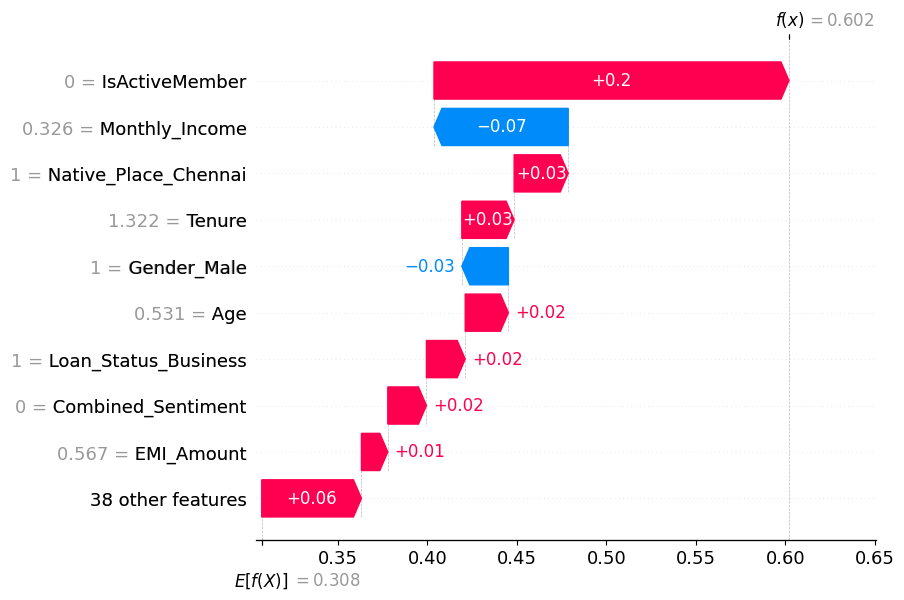

In [ ]:
shap.plots.waterfall(shap_values[9])

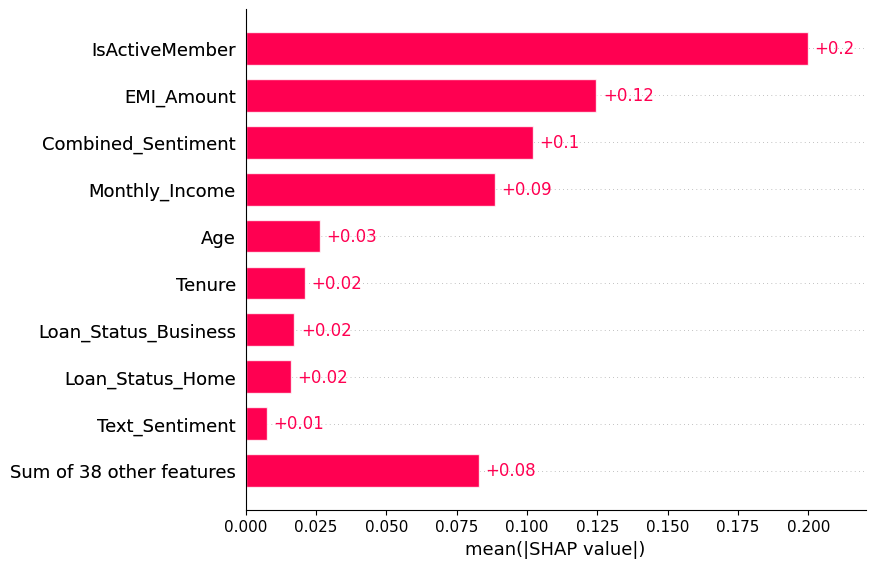

In [ ]:
shap.plots.bar(shap_values)

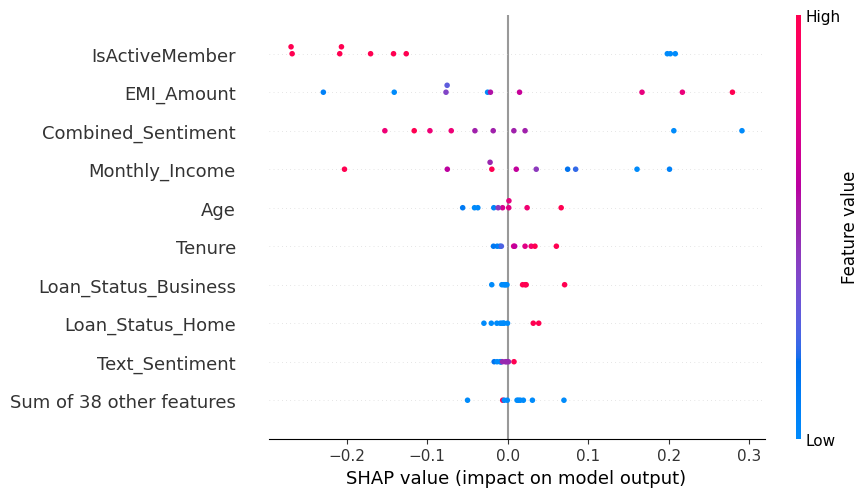

In [ ]:
shap.plots.beeswarm(shap_values)

In [ ]:
print(shap_values.shape)
print(X_test_clean.shape)
print(X_test_clean.dtypes)


(10, 47)
(30000, 47)
Age                            float32
Tenure                         float32
Balance                        float32
NumOfProducts                  float32
HasCrCard                      float32
IsActiveMember                 float32
Monthly_Income                 float32
CreditScore                    float32
EMI_Amount                     float32
Text_Sentiment                 float32
Combined_Sentiment             float32
Gender_Male                    float32
Gender_Other                   float32
Geography_Gujarat              float32
Geography_Karnataka            float32
Geography_Maharashtra          float32
Geography_Rajasthan            float32
Geography_Tamil Nadu           float32
Geography_Telangana            float32
Geography_Uttar Pradesh        float32
Geography_West Bengal          float32
Marital_Status_Married         float32
Marital_Status_Single          float32
Marital_Status_Widowed         float32
Loan_Status_Business           float32
Loan

In [ ]:
print("Branch_Churn_Rate" in shap_values.feature_names)

True


In [ ]:
feature_columns = X_train.columns.tolist()
feature_columns


['Age',
 'Tenure',
 'Balance',
 'NumOfProducts',
 'HasCrCard',
 'IsActiveMember',
 'Monthly_Income',
 'CreditScore',
 'EMI_Amount',
 'Text_Sentiment',
 'Combined_Sentiment',
 'Gender_Male',
 'Gender_Other',
 'Geography_Gujarat',
 'Geography_Karnataka',
 'Geography_Maharashtra',
 'Geography_Rajasthan',
 'Geography_Tamil Nadu',
 'Geography_Telangana',
 'Geography_Uttar Pradesh',
 'Geography_West Bengal',
 'Marital_Status_Married',
 'Marital_Status_Single',
 'Marital_Status_Widowed',
 'Loan_Status_Business',
 'Loan_Status_Education',
 'Loan_Status_Gold',
 'Loan_Status_Home',
 'Loan_Status_Multiple',
 'Loan_Status_Personal',
 'Native_Place_Bangalore',
 'Native_Place_Chennai',
 'Native_Place_Delhi',
 'Native_Place_Hyderabad',
 'Native_Place_Jaipur',
 'Native_Place_Kolkata',
 'Native_Place_Lucknow',
 'Native_Place_Mumbai',
 'Native_Place_Pune',
 'Account_Type_Joint',
 'Account_Type_NRI',
 'Account_Type_Premium',
 'Account_Type_Salary',
 'Account_Type_Savings',
 'Account_Type_Senior Citizen',

In [ ]:
user_input = {
    'Age': 20,
    'Gender': 'Male',
    'Geography': 'Tamil Nadu',
    'Native_Place': 'Hyderabad',
    'Marital_Status': 'Married',
    'Tenure': 8,
    'Account_Type': 'Savings',
    'Balance': 1000,
    'NumOfProducts': 4,
    'HasCrCard': 1,
    'IsActiveMember': 0,
    'EstimatedSalary': 3000000,
    'Monthly_Income': 3000000,
    'CreditScore': 300,
    'Loan_Status': 'Auto',
    'EMI_Amount': 50000,
    'Emoji_Sentiment': 0.9,
    'Text_sentiment': 0.9,
    'Combined_Sentiment': 0.9,
    'Branch_Churn_Rate': 1
}

input_df = pd.DataFrame([user_input])







In [ ]:
input_encoded = pd.get_dummies(input_df)




In [ ]:
input_encoded



,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Monthly_Income,CreditScore,EMI_Amount,Emoji_Sentiment,Text_sentiment,Combined_Sentiment,Branch_Churn_Rate,Gender_Male,Geography_Tamil Nadu,Native_Place_Hyderabad,Marital_Status_Married,Account_Type_Savings,Loan_Status_Auto
0,20,8,1000,4,1,0,3000000,3000000,300,50000,0.9,0.9,0.9,1,True,True,True,True,True,True


In [ ]:
for col in encoded_columns:
    if col not in input_encoded:
        input_encoded[col] = 0


for col in numerical_cols:
    if col not in input_encoded.columns:
        input_encoded[col] = 0


input_encoded = input_encoded[encoded_columns]

In [ ]:
encoded_columns

['Age',
 'Tenure',
 'Balance',
 'NumOfProducts',
 'HasCrCard',
 'IsActiveMember',
 'Monthly_Income',
 'CreditScore',
 'EMI_Amount',
 'Text_Sentiment',
 'Combined_Sentiment',
 'Gender_Male',
 'Gender_Other',
 'Geography_Gujarat',
 'Geography_Karnataka',
 'Geography_Maharashtra',
 'Geography_Rajasthan',
 'Geography_Tamil Nadu',
 'Geography_Telangana',
 'Geography_Uttar Pradesh',
 'Geography_West Bengal',
 'Marital_Status_Married',
 'Marital_Status_Single',
 'Marital_Status_Widowed',
 'Loan_Status_Business',
 'Loan_Status_Education',
 'Loan_Status_Gold',
 'Loan_Status_Home',
 'Loan_Status_Multiple',
 'Loan_Status_Personal',
 'Native_Place_Bangalore',
 'Native_Place_Chennai',
 'Native_Place_Delhi',
 'Native_Place_Hyderabad',
 'Native_Place_Jaipur',
 'Native_Place_Kolkata',
 'Native_Place_Lucknow',
 'Native_Place_Mumbai',
 'Native_Place_Pune',
 'Account_Type_Joint',
 'Account_Type_NRI',
 'Account_Type_Premium',
 'Account_Type_Salary',
 'Account_Type_Savings',
 'Account_Type_Senior Citizen',

In [ ]:
input_encoded.columns

Index(['Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'Monthly_Income', 'CreditScore', 'EMI_Amount',
       'Text_Sentiment', 'Combined_Sentiment', 'Gender_Male', 'Gender_Other',
       'Geography_Gujarat', 'Geography_Karnataka', 'Geography_Maharashtra',
       'Geography_Rajasthan', 'Geography_Tamil Nadu', 'Geography_Telangana',
       'Geography_Uttar Pradesh', 'Geography_West Bengal',
       'Marital_Status_Married', 'Marital_Status_Single',
       'Marital_Status_Widowed', 'Loan_Status_Business',
       'Loan_Status_Education', 'Loan_Status_Gold', 'Loan_Status_Home',
       'Loan_Status_Multiple', 'Loan_Status_Personal',
       'Native_Place_Bangalore', 'Native_Place_Chennai', 'Native_Place_Delhi',
       'Native_Place_Hyderabad', 'Native_Place_Jaipur', 'Native_Place_Kolkata',
       'Native_Place_Lucknow', 'Native_Place_Mumbai', 'Native_Place_Pune',
       'Account_Type_Joint', 'Account_Type_NRI', 'Account_Type_Premium',
       'Account_Type_Sal

In [ ]:
input_encoded.dtypes




,0
Age,int64
Tenure,int64
Balance,int64
NumOfProducts,int64
HasCrCard,int64
IsActiveMember,int64
Monthly_Income,int64
CreditScore,int64
EMI_Amount,int64
Text_Sentiment,int64


In [ ]:
bool_cols = input_encoded.select_dtypes(include=['bool']).columns
input_encoded[bool_cols] = input_encoded[bool_cols].astype(int)


/tmp/ipython-input-376-409561774.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  input_encoded[bool_cols] = input_encoded[bool_cols].astype(int)


In [ ]:
input_encoded.dtypes


,0
Age,int64
Tenure,int64
Balance,int64
NumOfProducts,int64
HasCrCard,int64
IsActiveMember,int64
Monthly_Income,int64
CreditScore,int64
EMI_Amount,int64
Text_Sentiment,int64


In [ ]:
input_encoded[numerical_cols] = scaler.transform(input_encoded[numerical_cols])

/tmp/ipython-input-378-2565281621.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  input_encoded[numerical_cols] = scaler.transform(input_encoded[numerical_cols])


In [ ]:
print(list(input_encoded.columns) == list(X_train.columns))


True


In [ ]:
input_encoded.fillna(0, inplace=True)



/tmp/ipython-input-380-4028717534.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  input_encoded.fillna(0, inplace=True)


In [ ]:
print('Exited' in input_encoded.columns)
print("Input shape:", input_encoded.shape)
X_train.shape

False
Input shape: (1, 47)


(70000, 47)

In [ ]:
prediction = model.predict(input_encoded)
print("Churn Probability:", round(prediction[0][0], 4))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Churn Probability: 0.0045
